In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from collections import Counter

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# הגדרת המיפוי (רק לידיעה, הדאטה כבר מספרי)
LABEL2ID = {"ENHANCER": 0, "PROMOTER": 1, "OCR": 2}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}
LABEL_MAP = ["ENHANCER", "PROMOTER", "OCR"]

In [2]:
def load_and_analyze(parquet_path):
    print("--- Loading Data ---")
    df = pd.read_parquet(parquet_path)
    
    X = df['sequence'].tolist()
    y = df['label'].values
    
    lengths = [len(s) for s in X]
    limit_95 = int(np.percentile(lengths, 95)) # אורך שמכסה 95% מהדאטה
    print(f"Average Length: {np.mean(lengths):.2f}")
    print(f"Max Length in data: {max(lengths)}")
    print(f"95th Percentile Length: {limit_95} (Recommended for CNN padding)")
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    return X_train, X_test, y_train, y_test, limit_95

# נתיב לקובץ שלך
path = 'unified_genomic_dataset/genomic_multiclass_balanced.parquet'
X_train, X_test, y_train, y_test, RECOMMENDED_LEN = load_and_analyze(path)

--- Loading Data ---
Average Length: 282.03
Max Length in data: 593
95th Percentile Length: 479 (Recommended for CNN padding)
Train size: 86714, Test size: 21679


In [3]:
# מילון המרה
DNA_DICT = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 4} 

def encode_and_pad(sequences, max_len):
    encoded_list = []
    for seq in sequences:
        # המרה למספרים, תווים לא מוכרים יקבלו 4
        num_seq = [DNA_DICT.get(base, 4) for base in seq] 
        encoded_list.append(num_seq)
    
    # ריפוד (Padding)
    # truncating='post': אם הרצף ארוך מדי, חתוך את הסוף
    # padding='post': אם הרצף קצר מדי, הוסף אפסים בסוף
    return pad_sequences(encoded_list, maxlen=max_len, padding='post', truncating='post', value=4)

# הכנת הדאטה לרשת
# משתמשים ב-Limit שמצאנו (למשל 500) או קובעים ידנית אם זה קצר מדי
FINAL_LEN = max(RECOMMENDED_LEN, 200) 
print(f"Encoding sequences with Max Length: {FINAL_LEN}")

X_train_cnn = encode_and_pad(X_train, FINAL_LEN)
X_test_cnn = encode_and_pad(X_test, FINAL_LEN)

# הופכים ל-One Hot בערוצים (Channels)
# קלט: (samples, length) -> פלט: (samples, length, 5)
X_train_cnn_ohe = tf.keras.utils.to_categorical(X_train_cnn, num_classes=5)
X_test_cnn_ohe = tf.keras.utils.to_categorical(X_test_cnn, num_classes=5)


Encoding sequences with Max Length: 479


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_dna_cnn(seq_length, num_classes=3):
    """
    Build 1D-CNN for DNA sequence classification
    
    Args:
        seq_length: Length of padded sequences (FINAL_LEN)
        num_classes: Number of output classes (3 for your case)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # First Conv Block - Multiple kernel sizes for different motif lengths
        layers.Conv1D(filters=96, kernel_size=4, activation='relu', 
                     input_shape=(seq_length, 5), padding='same'),
        layers.Conv1D(filters=96, kernel_size=8, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=3),
        layers.Dropout(0.25),
        
        # Second Conv Block
        layers.Conv1D(filters=192, kernel_size=4, activation='relu', padding='same'),
        layers.Conv1D(filters=192, kernel_size=8, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=3),
        layers.Dropout(0.3),
        
        # Third Conv Block - Capture longer-range dependencies
        layers.Conv1D(filters=256, kernel_size=4, activation='relu', padding='same'),
        layers.Conv1D(filters=256, kernel_size=8, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=2),
        layers.Dropout(0.35),
        
        # Dense layers with more capacity
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    # Calculate class weights to handle imbalance
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.AUC(multi_label=False, name='auc'),
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')]
    )
    
    return model

# Enable Metal GPU acceleration for M2
import os
os.environ['TF_METAL_DEVICE_PLACEMENT_LOGGING'] = '1'

# Build the model
model = build_dna_cnn(seq_length=FINAL_LEN, num_classes=3)
model.summary()

# Convert labels to categorical (if not already done)
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=3)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=3)

print(f"\nTraining samples: {len(X_train_cnn_ohe)}")
print(f"Sequence length: {FINAL_LEN}")
print("Note: First epoch may be slow due to model compilation")

# Callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,  # More patience for complex model
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=7,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
history = model.fit(
    X_train_cnn_ohe, y_train_cat,
    validation_split=0.15,
    epochs=30,  # More epochs for deeper model
    batch_size=512,  # Smaller batch for better gradient estimates
    callbacks=callbacks,
    verbose=1
)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 479, 96)        │         2,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 479, 96)        │        73,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 479, 96)        │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 159, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 159, 96)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 159, 192)       │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 159, 192)       │       295,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 159, 192)       │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 53, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 53, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 53, 256)        │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 53, 256)        │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 53, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6656)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,408,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,645,443 (17.72 MB)

 Trainable params: 4,643,075 (17.71 MB)

 Non-trainable params: 2,368 (9.25 KB)


Training samples: 86714
Sequence length: 479
Note: First epoch may be slow due to model compilation
Epoch 1/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.6510 - auc: 0.8483 - loss: 0.8354 - precision: 0.6604 - recall: 0.6355 - val_accuracy: 0.3322 - val_auc: 0.4991 - val_loss: 5.9309 - val_precision: 0.3322 - val_recall: 0.3322 - learning_rate: 5.0000e-04
Epoch 2/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - accuracy: 0.7125 - auc: 0.9115 - loss: 0.4904 - precision: 0.7156 - recall: 0.7061 - val_accuracy: 0.3322 - val_auc: 0.5024 - val_loss: 5.7313 - val_precision: 0.3322 - val_recall: 0.3322 - learning_rate: 5.0000e-04
Epoch 3/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.7288 - auc: 0.9184 - loss: 0.4560 - precision: 0.7308 - recall: 0.7245 - val_accuracy: 0.6554 - val_auc: 0.7128 - val_loss: 2.3466 - val_precision: 0.6554 - val_recall: 0.6554 - learning_rate: 5.0000e-04
Epoch 4/30
144/144 ━━━━━━━━━━━━━━━━━━━━ 334s 2s/step - accuracy: 0.7377 - auc: 0.9230 

678/678 - 39s - 57ms/step - accuracy: 0.7789 - auc: 0.9419 - loss: 0.4028 - precision: 0.7791 - recall: 0.7788

Test Accuracy: 0.7789
Test AUC: 0.9419
Test Precision: 0.7791
Test Recall: 0.7788
678/678 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step


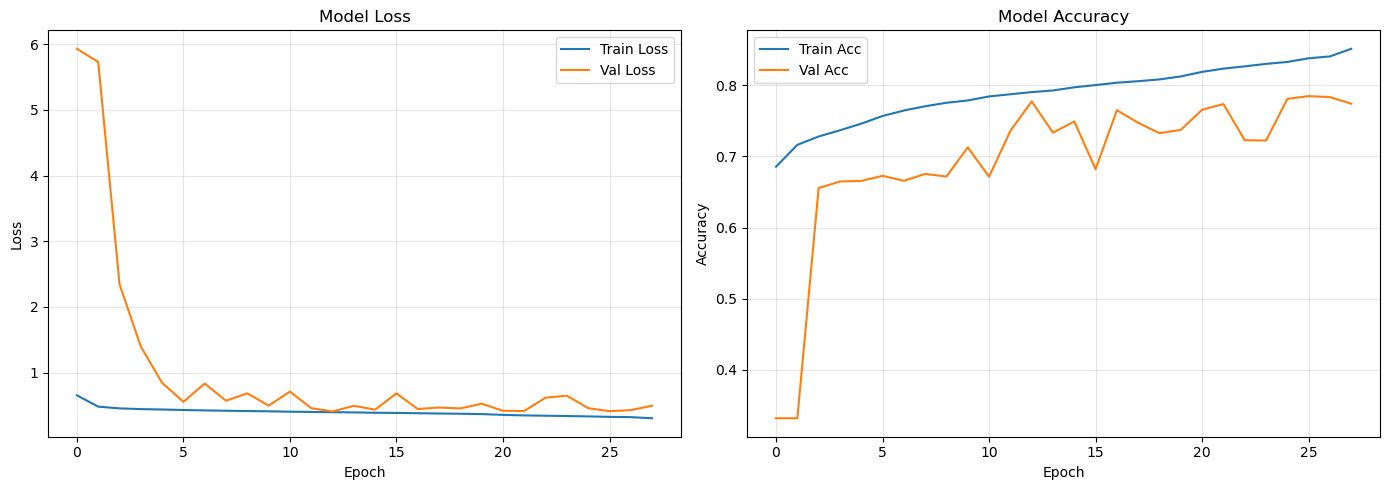


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.44      0.57      7226
           1       0.99      1.00      1.00      7226
           2       0.62      0.89      0.73      7227

    accuracy                           0.78     21679
   macro avg       0.81      0.78      0.77     21679
weighted avg       0.81      0.78      0.77     21679



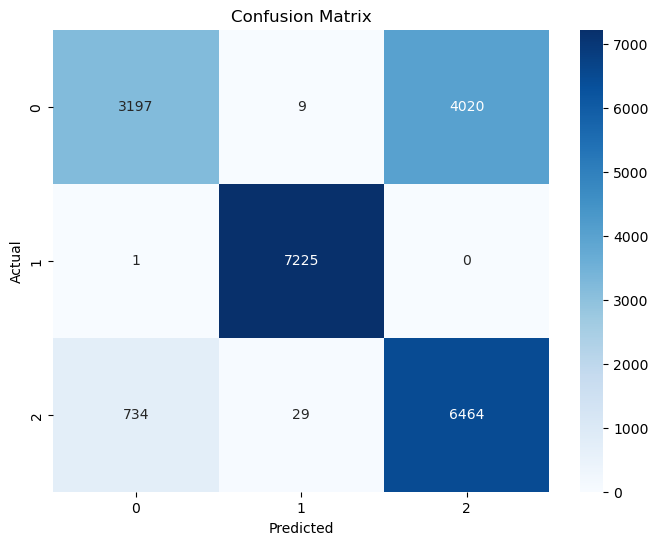

In [7]:
# Unpack all 5 values returned by the model
test_loss, test_acc, test_auc, test_precision, test_recall = model.evaluate(X_test_cnn_ohe, y_test_cat, verbose=2)

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Make predictions
predictions = model.predict(X_test_cnn_ohe)
predicted_classes = predictions.argmax(axis=1)

# Optional: Plot training history
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Model Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Train Acc')
ax2.plot(history.history['val_accuracy'], label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Model Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_test_classes = y_test_cat.argmax(axis=1)
print("\nClassification Report:")
print(classification_report(y_test_classes, predicted_classes))

# Confusion Matrix
cm = confusion_matrix(y_test_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [6]:
model.save("vast_dna_element_classifier_model.keras")